In [3]:
import os, csv, random

from __future__ import division
from matplotlib import  pyplot as plt
from memory_profiler import profile
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import scipy.io as sio
import seaborn as sns

%matplotlib inline

# Generate score for videos, and find all possible pairs

In [114]:
video_num = 30

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)
print 'Total number of pairs for %d videos is: ' %video_num, total_pairs

Total number of pairs for 30 videos is:  435


# SGD
Assuming the pair $(w_i,w_j)$ means $w_i > w_j$, this function calculates $\frac{\partial L}{\partial w_i} = \frac{exp(w_j-w_i)}{1+exp(w_j-w_i)}$, where $w_i$ represent the weight to be taken derivative of. Return value is the gradient of the log likelihood function with respect to $w_i$

In [118]:
def calc_gradient(pairs, w, w_i):
    gradient = 0
    
    for pair in pairs:
        if w_i == pair[0]:
            out = -1
        elif w_i == pair[1]:
            out = 1  
        else:
            out = 0
            
        gradient -= out/(1/(np.exp(w[pair[1]]-w[pair[0]])+0.00001)+1)
    
    return gradient

$w_{old}$ saves the original values of the gradient, so that later when updating the values, the values to be updated are still using the original value

In [119]:
def update_gradient(pairs, w, eta):
    w_old = w
    for i in range(len(w)):
        w[i] -= eta*calc_gradient(pairs, w_old, i)
    return w

In [122]:
w = np.zeros(30)
pairs = pairs_truth
results = []
for i in range(10000):
    
    w = update_gradient(pairs, w, 0.05)
    if i % 1000 ==0:
        print w
    results.append(w[0])
    

[ 0.67500337 -0.38313294  0.0716007  -0.57929718 -0.0222492   0.52803165
  0.22157901  0.46882183 -0.73693939 -0.62812265 -0.07051676 -0.11963592
  0.03185848  0.43146229  0.1261497   0.62457747 -0.48299096  0.27293544
 -0.53045922  0.32602451  0.57198626 -0.28497906 -0.18144026  0.37082428
 -0.68376394 -0.22553276 -0.42272653  0.18248322  0.73021139 -0.32853651]
[ 1350.32318298  -750.59762819   150.02698199 -1150.12389232   -49.97924939
  1050.37146933   450.12142512   949.68970018 -1449.15036803 -1249.12044183
  -149.9878685   -249.9129047     50.06367361   849.74757097   249.89953234
  1249.05356321  -949.72956071   549.60920912 -1048.92250598   649.5051223
  1147.93101829  -550.01739754  -349.87603903   748.96584984 -1347.79551649
  -449.5250815   -848.49882899   349.54177489  1446.78109626  -648.9857458 ]
[ 2700.32318298 -1500.59762819   300.02698199 -2300.12389232   -99.97924939
  2100.37146933   900.12142512  1899.68970018 -2899.15036803 -2499.12044183
  -299.9878685   -499.9129

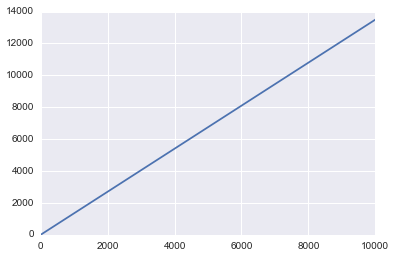

In [123]:
plt.plot(results)

# Generate Data using Generative function 